# Dataset Examples

Extract and display example images from the 2 datasets: **Airbus** and **SatCen**.

## Airbus vs SatCen

Show images from both datasets in the same plot.
- 2 rows, one for each dataset (Airbus top, SatCen bottom)
- 4 images per row

In [47]:
import pathlib
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw as Drawer
from fastai.vision.core import PILMask

### Load Datasets

In [2]:
# get paths to both datasets
airbus_path = pathlib.Path('../airbus_dataset/')
satcen_path = pathlib.Path('../satcen_dataset/full/')

# load the Airbus segmentation masks (in run-length encoding format)
airbus_masks = pd.read_csv(airbus_path/'train_ship_segmentations_v2.csv').set_index('ImageId')

# select only Airbus images with ships
# 
# images that have a ship have str as the type of EncodedPixels, while images that 
# do not have a ship have float as the type of EncodedPixels
# 
# reference for lambda function: https://stackoverflow.com/questions/39275533/select-row-from-a-dataframe-based-on-the-type-of-the-objecti-e-str
airbus_ship_images = airbus_masks[airbus_masks['EncodedPixels'].apply(lambda x: isinstance(x, str))].index.unique().tolist()

# load the SatCen label
with open(satcen_path/'labels.json', 'rb') as satcen_labels_file:
    satcen_labels_json = json.load(satcen_labels_file)
    
# select only SatCen images with skiffs
satcen_skiff_images = [entry['name'] for entry in satcen_labels_json if len(entry['bounding_boxes']) > 0]

### Define Functions for Airbus Handling

Two helper function for easier handling of the Airbus dataset:
- **get_image_mask**: returns the mask (as a binary numpy array with the same shape as the image) of an Airbus image
- **get_bounding_boxes_from_mask**: returns the rotated bounding boxes associated with a given mask

In [3]:
def get_image_mask(img):
    """
        Generates the segmentation mask of an Airbus image from run-length encoding
        
        Arguments
        ---------
        img: str
            Image filename
            
        Returns
        -------
        image_mask: ndarray
            Binary segmentation mask of the given image
    """
    
    # create a 1D array equal to legnth*width of the initial image 
    image_mask = np.zeros(768*768, dtype=np.uint8)

    # get all the ship masks in the image
    # slicing necessary to ensure loc returns df of masks, not actual value of mask
    for mask in airbus_masks.loc[img:img]['EncodedPixels']: 
        if isinstance(mask, str):
            mask = mask.split()
            mask = [int(i) for i in mask]
            for i in range(0, len(mask), 2):
                image_mask[mask[i]:mask[i]+mask[i+1]] = 1

    # reshape the image mask
    image_mask = image_mask.reshape([768, 768]).T
    
    return image_mask

def get_bounding_boxes_from_mask(mask):
    """
        Generates the rotated bounding boxes associated with
        a given binary segmentation mask
        
        Reference
        ---------
        https://www.kaggle.com/code/frappuccino/from-masks-to-rotating-bounding-boxes-using-opencv
        
        Arguments
        ---------
        mask: ndarray
            Binary segmentation mask
            
        Returns
        -------
        bounding_boxes: list[list]
            List of bounding boxes. Each bounding box is a list of (x, y) coordinates
    """
    
    # the list of bounding boxes
    bounding_boxes = []
    
    # find the contours
    contours, _ = cv2.findContours(mask, 1, 1)
    
    # loop through each contour identified
    for contour in contours:
        
        # determine the (rotated) rectangle with the minimum area
        # associated with this contour
        min_rect = cv2.minAreaRect(contour)
        
        # convert to box points (coordinates)
        box = cv2.boxPoints(min_rect)
        
        # append the rotated rectangle to the list
        bounding_boxes.append(box)
        
    return bounding_boxes

### Show Airbus vs SatCen Images

Only use images with ships/skiffs.

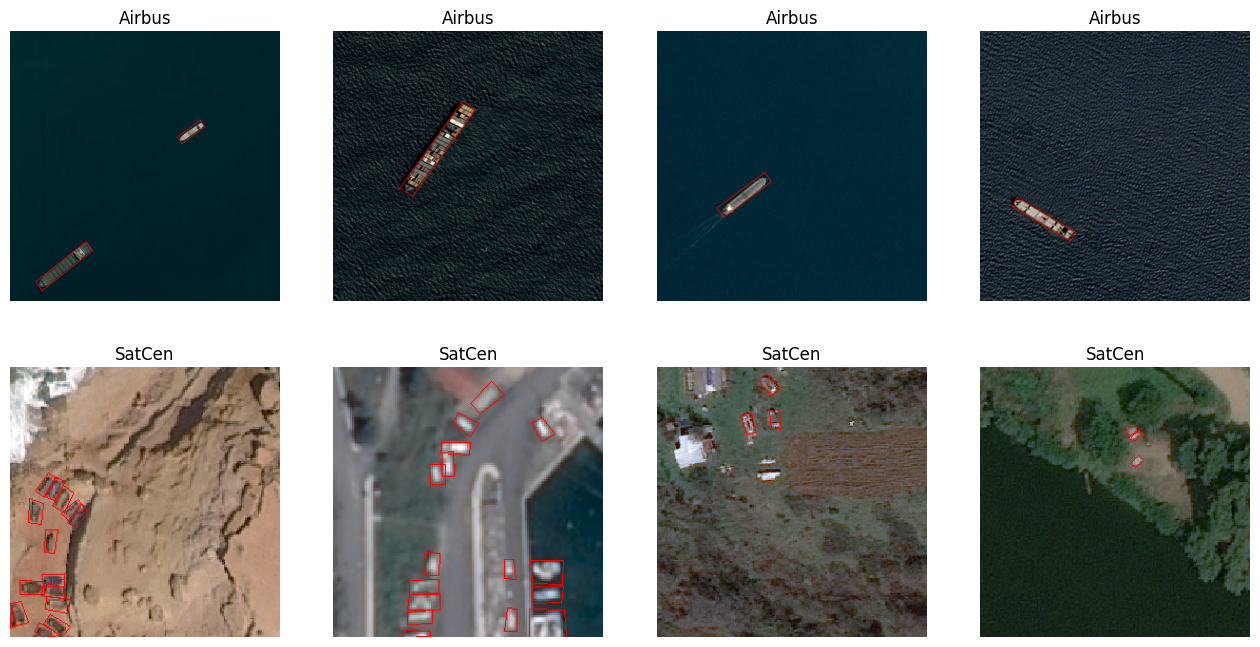

In [44]:
# indices of the selected Airbus and SatCen images
airbus_indices = [7, 9, 14, 15]
satcen_indices = [0, 1, 2, 3]

# set up the figure
plt.subplots(2, 4, figsize=(16, 8))

# loop through Airbus indices
for i, airbus_idx in enumerate(airbus_indices):
    
    # get the image filename
    img_fn = airbus_ship_images[airbus_idx]
    
    # load the image
    img = Image.open(airbus_path/'train_v2'/img_fn)
    
    # get the bounding boxes
    bounding_boxes = get_bounding_boxes_from_mask(get_image_mask(img_fn))
    
    # draw the bounding boxes
    drawer = Drawer.Draw(img)
    
    for bounding_box in bounding_boxes:
        drawer.polygon(bounding_box, outline=(255, 0, 0), width=2)
        
    # plot the image
    plt.subplot(2, 4, i + 1)
    plt.title('Airbus')
    plt.imshow(img)
    plt.axis('off')
    
# loop through SatCen indices
for i, satcen_idx in enumerate(satcen_indices):
    
    # get the image filename
    img_fn = satcen_skiff_images[satcen_idx]
    
    # load the image
    img = Image.open(satcen_path/'pictures'/img_fn)
    
    # get the bounding boxes
    bounding_boxes = list(filter(lambda x: x['name'] == img_fn, satcen_labels_json))[0]['bounding_boxes']

    # draw the bounding boxes
    drawer = Drawer.Draw(img)
    
    for bounding_box in bounding_boxes:
        
        # convert coordinates to required format
        coords = [(c['x'], c['y']) for c in bounding_box]
        
        drawer.polygon(coords, outline=(255, 0, 0))    
        
    # plot the image
    plt.subplot(2, 4, i + 5)
    plt.title('SatCen')
    plt.imshow(img)
    plt.axis('off')
    
# display the figure
plt.show()
    

## Overlapping Bounding Boxes

Show images with the overlapping bounding boxes problem.
- 2 rows, top one for RGB image (with bounding boxes) and bottom one for binary segmentation masks
- 4 images per row

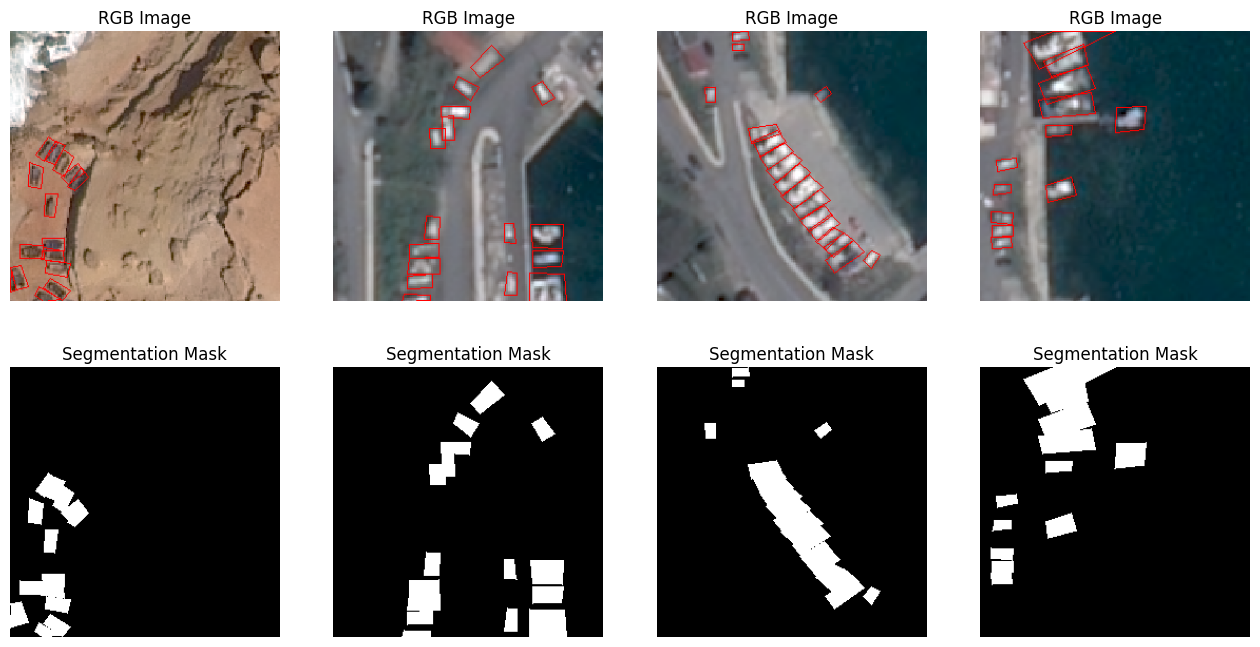

In [54]:
# indices of images with the overlapping bounding boxes problem
overlapping_bb_indices = [0, 1, 4, 6]

# set up the figure
plt.subplots(2, 4, figsize=(16, 8))

# loop through the indices
for i, img_idx in enumerate(overlapping_bb_indices):
    
    # get the image filename
    img_fn = satcen_skiff_images[img_idx]
    
    # get the RGB image
    rgb_img = Image.open(satcen_path/'pictures'/img_fn)
    
    # get the bounding boxes
    bounding_boxes = list(filter(lambda x: x['name'] == img_fn, satcen_labels_json))[0]['bounding_boxes']

    # draw the bounding boxes
    drawer = Drawer.Draw(rgb_img)
    
    for bounding_box in bounding_boxes:
        
        # convert coordinates to required format
        coords = [(c['x'], c['y']) for c in bounding_box]
        
        drawer.polygon(coords, outline=(255, 0, 0))  
        
    # show the image
    plt.subplot(2, 4, i + 1)
    plt.title('RGB Image')
    plt.imshow(rgb_img)
    plt.axis('off')
    
    # get the binary segmentation mask
    mask = PILMask.create(satcen_path/'ground_truth_masks'/f'{img_fn[:-4]}_L.png')
    
    # show the mask
    plt.subplot(2, 4, i + 5)
    plt.title('Segmentation Mask')
    plt.imshow(mask, cmap='gray')
    plt.axis('off')